In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Data Loader

In [2]:
def load_stooq_stock(symbol, years=3):
    url = f"https://stooq.pl/q/d/l/?s={symbol}&i=d"
    df = pd.read_csv(url)

    # Clean column names
    df.columns = [c.strip() for c in df.columns]

    # --- FIX: detect date column safely ---
    if 'Date' in df.columns:
        date_col = 'Date'
    elif 'Data' in df.columns:
        date_col = 'Data'
    else:
        raise ValueError(f"No Date column found for {symbol}. Columns: {df.columns}")

    # Rename other columns
    df.rename(columns={
        'Otwarcie': 'Open',
        'Najwyzszy': 'High',
        'Najnizszy': 'Low',
        'Zamkniecie': 'Close',
        'Wolumen': 'Volume'
    }, inplace=True)

    # Date handling
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    df.sort_index(inplace=True)

    # Cutoff to last N years
    cutoff_date = datetime.today() - timedelta(days=365 * years)
    df = df[df.index >= cutoff_date]

    # Returns
    df['returns'] = df['Close'].pct_change()

    return df.dropna()


# 3️⃣ Trend Signal Construction

In [3]:
def compute_trend_signal(df, lookback=60):
    df = df.copy()
    
    df['price_diff'] = df['Close'] - df['Close'].shift(lookback)
    df['signal'] = np.sign(df['price_diff'])
    
    return df.dropna()


# 4️⃣ Position Logic

In [4]:
def compute_positions(df):
    df = df.copy()
    
    df['position'] = df['signal'].shift(1)
    df['position'] = df['position'].fillna(0)
    
    return df


# 5️⃣ Strategy Returns

In [5]:
def compute_strategy_returns(df):
    df = df.copy()
    
    df['strategy_return'] = df['position'] * df['returns']
    df['equity_curve'] = (1 + df['strategy_return']).cumprod()
    
    return df


# 6️⃣ Performance Metrics

In [6]:
def performance_metrics(df):
    returns = df['strategy_return']
    
    sharpe = np.sqrt(252) * returns.mean() / returns.std()
    
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    
    metrics = {
        'Total Return': cumulative.iloc[-1] - 1,
        'Sharpe': sharpe,
        'Max Drawdown': drawdown.min(),
        'Win Rate': (returns > 0).mean()
    }
    
    return metrics

def buy_and_hold_return(df):
    """
    Compute buy-and-hold return over the sample period.
    """
    start_price = df['Close'].iloc[0]
    end_price = df['Close'].iloc[-1]
    return (end_price / start_price) - 1



In [7]:

def calculate_ev_per_trade(trade_returns):
    """
    Calculate Expected Value (EV) per trade.

    Parameters
    ----------
    trade_returns : array-like
        List or Series of per-trade returns (e.g. +0.05, -0.02)

    Returns
    -------
    dict
        EV per trade and supporting statistics
    """

    trade_returns = np.array(trade_returns)

    wins = trade_returns[trade_returns > 0]
    losses = trade_returns[trade_returns < 0]

    if len(trade_returns) == 0:
        return {
            'EV per Trade': np.nan,
            'Win Rate': np.nan,
            'Avg Win': np.nan,
            'Avg Loss': np.nan,
            'Payoff Ratio': np.nan
        }

    win_rate = len(wins) / len(trade_returns)
    loss_rate = 1 - win_rate

    avg_win = wins.mean() if len(wins) > 0 else 0.0
    avg_loss = losses.mean() if len(losses) > 0 else 0.0  # negative

    ev = win_rate * avg_win + loss_rate * avg_loss
    
    return ev

# 7️⃣ Trade-Level Statistics

In [8]:
def trade_statistics(df):
    df = df.copy()

    # Identify trade boundaries when position changes
    df['pos_change'] = df['position'].diff()

    trade_returns = []
    current_trade = []

    for ret, change in zip(df['strategy_return'], df['pos_change']):
        if change != 0 and len(current_trade) > 0:
            trade_returns.append(np.sum(current_trade))
            current_trade = []

        current_trade.append(ret)

    # Append last trade
    if len(current_trade) > 0:
        trade_returns.append(np.sum(current_trade))

    trade_returns = pd.Series(trade_returns)

    return {
        'Number of Trades': len(trade_returns),
        'Win Rate (trade)': (trade_returns > 0).mean(),
        'Average Win': trade_returns[trade_returns > 0].mean(),
        'Average Loss': trade_returns[trade_returns < 0].mean(),
        'Payoff Ratio': abs(
            trade_returns[trade_returns > 0].mean() /
            trade_returns[trade_returns < 0].mean()
        )
    }


# 8️⃣ Running the Strategy

In [9]:
def run_trend_following(symbol, lookback=60, years=3):
    df = load_stooq_stock(symbol, years=years)
    df = compute_trend_signal(df, lookback=lookback)
    df = compute_positions(df)
    df = compute_strategy_returns(df)
    bh_return = buy_and_hold_return(df)


    perf = performance_metrics(df)
    trades = trade_statistics(df)
    
        # ---- EV per Trade (simple & correct) ----
    trade_id = (df['position'] != df['position'].shift()).cumsum()
    trade_returns = (
        df.loc[df['position'] != 0, 'strategy_return']
        .groupby(trade_id)
        .sum()
        .values
    )

    ev_per_trade = calculate_ev_per_trade(trade_returns)
    # ----------------------------------------

    results = {
        'Symbol': symbol.upper(),
        'Total Return': perf['Total Return'],
        'Buy & Hold Return': bh_return,
        'Sharpe': perf['Sharpe'],
        'Max Drawdown': perf['Max Drawdown'],
        #'Daily Win Rate': perf['Win Rate (daily)'],
        'Trades': trades['Number of Trades'],
        'Trade Win Rate': trades['Win Rate (trade)'],
        'Avg Win': trades['Average Win'],
        'Avg Loss': trades['Average Loss'],
        'Payoff Ratio': trades['Payoff Ratio'],
        'EV per Trade': ev_per_trade
    }

    return results



In [10]:
symbols = [
    # Tech / Growth
    'NVDA.US','AAPL.US','MSFT.US','META.US','AMZN.US','GOOGL.US','AMD.US',

    # Cyclical
    'JPM.US','GS.US','XOM.US','CVX.US','CAT.US',

    # Defensive
    'PG.US','KO.US','UNH.US','COST.US',

    # ETFs
    'SPY.US','QQQ.US','IWM.US','XLK.US','XLF.US','XLE.US','XLV.US','TLT.US'
]

results = []

for sym in symbols:
    res = run_trend_following(sym)
    results.append(res)

tf_results = pd.DataFrame(results)
tf_results


,Symbol,Total Return,Buy & Hold Return,Sharpe,Max Drawdown,Trades,Trade Win Rate,Avg Win,Avg Loss,Payoff Ratio,EV per Trade
0,NVDA.US,1.232284,5.928106,0.835894,-0.602905,39,0.384615,0.147098,-0.046294,3.177439,0.030045
1,AAPL.US,0.559679,0.554345,0.759493,-0.222012,21,0.428571,0.075382,-0.012899,5.844173,0.026827
2,MSFT.US,-0.101564,0.598422,-0.065860,-0.336029,43,0.279070,0.041437,-0.017902,2.314664,-0.000948
3,META.US,0.185347,1.820967,0.350460,-0.481956,41,0.365854,0.070908,-0.029105,2.436251,0.008400
4,AMZN.US,0.130696,1.228009,0.299611,-0.305469,42,0.309524,0.070476,-0.023603,2.985908,0.006227
5,GOOGL.US,1.361015,2.120744,1.219110,-0.269741,28,0.392857,0.118291,-0.020288,5.830591,0.036170
6,AMD.US,0.454041,1.882319,0.522705,-0.601571,23,0.304348,0.232629,-0.058384,3.984471,0.034211
7,JPM.US,-0.129845,1.191244,-0.110113,-0.333630,34,0.264706,0.064530,-0.027052,2.385423,-0.002075
8,GS.US,0.380956,1.721663,0.565187,-0.482547,21,0.285714,0.188887,-0.050530,3.738086,0.021295
9,XOM.US,-0.519349,0.171189,-1.096399,-0.614561,56,0.178571,0.034901,-0.022531,1.548985,-0.012089


In [ ]:
df.head(30)

In [64]:
def compute_hurst(price_series, max_lag=100):
    """
    Compute Hurst exponent using log-log regression.
    """
    series = np.log(price_series.dropna())
    
    lags = range(2, max_lag)
    tau = [np.std(series.diff(lag).dropna()) for lag in lags]
    
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0]
    
    return hurst

In [65]:
def compute_hurst_for_universe(symbols, years=3):
    results = []

    for sym in symbols:
        df = load_stooq_stock(sym, years=years)
        h = compute_hurst(df['Close'])

        results.append({
            'Symbol': sym.upper(),
            'Hurst': h
        })

    return pd.DataFrame(results)

In [66]:
hurst_df = compute_hurst_for_universe(symbols)
hurst_df.sort_values('Hurst', ascending=False)


,Symbol,Hurst
7,AMD.US,0.502162
5,NVDA.US,0.493794
8,AAPL.US,0.480421
9,MSFT.US,0.478652
1,KO.US,0.478594
3,JNJ.US,0.472147
4,MCD.US,0.463562
6,TSLA.US,0.438148
2,PEP.US,0.418189
10,SPY.US,0.412724


In [71]:
import numpy as np

def buy_and_hold_metrics(df):
    """
    Compute Buy & Hold Sharpe and Max Drawdown.
    """
    returns = df['returns']

    # Sharpe ratio
    sharpe = np.sqrt(252) * returns.mean() / returns.std()

    # Equity curve
    equity = (1 + returns).cumprod()

    # Drawdown
    peak = equity.cummax()
    drawdown = (equity - peak) / peak
    max_dd = drawdown.min()

    return sharpe, max_dd


In [72]:
def run_trend_following(symbol, lookback=60, years=3):
    df = load_stooq_stock(symbol, years=years)

    # Buy & Hold metrics
    bh_return = buy_and_hold_return(df)
    bh_sharpe, bh_max_dd = buy_and_hold_metrics(df)

    # Trend Following
    df_tf = compute_trend_signal(df, lookback=lookback)
    df_tf = compute_positions(df_tf)
    df_tf = compute_strategy_returns(df_tf)

    perf = performance_metrics(df_tf)
    trades = trade_statistics(df_tf)

    return {
        'Symbol': symbol.upper(),

        # Buy & Hold
        'BH Return': bh_return,
        'BH Sharpe': bh_sharpe,
        'BH Max DD': bh_max_dd,

        # Trend Following
        'TF Return': perf['Total Return'],
        'TF Sharpe': perf['Sharpe'],
        'TF Max DD': perf['Max Drawdown'],

        # Trade stats
        'Trades': trades['Number of Trades'],
        'Trade Win Rate': trades['Win Rate (trade)'],
        'Payoff Ratio': trades['Payoff Ratio'],
        #'EV per Trade': trades['EV per Trade']
    }


In [73]:
results = [run_trend_following(sym) for sym in symbols]
comparison_df = pd.DataFrame(results)
comparison_df(index=False)

,Symbol,BH Return,BH Sharpe,BH Max DD,TF Return,TF Sharpe,TF Max DD,Trades,Trade Win Rate,Payoff Ratio
0,PG.US,-0.020149,-0.014299,-0.231831,-0.323012,-0.778971,-0.389722,47,0.276596,1.138154
1,KO.US,0.178733,0.377204,-0.185381,0.013407,0.107238,-0.222117,28,0.428571,1.444031
2,PEP.US,-0.176320,-0.309788,-0.347236,-0.417627,-0.962169,-0.492111,45,0.177778,1.535176
3,JNJ.US,0.235391,0.468549,-0.185809,0.436707,0.856249,-0.142044,31,0.548387,2.213847
4,MCD.US,0.153022,0.308897,-0.182045,-0.088693,-0.114626,-0.309078,24,0.333333,1.561781
5,NVDA.US,9.650526,1.827049,-0.368868,1.566927,0.939341,-0.602905,34,0.441176,2.841331
6,TSLA.US,2.486256,0.986157,-0.537657,-0.237353,0.138256,-0.549535,44,0.363636,1.939550
7,AMD.US,1.944704,0.942155,-0.630003,0.439159,0.515923,-0.601571,21,0.333333,3.436640
8,AAPL.US,0.947148,0.997644,-0.333606,0.605624,0.803420,-0.220851,20,0.450000,5.579347
9,MSFT.US,1.056775,1.141556,-0.238794,-0.032778,0.058271,-0.336029,43,0.279070,2.666140


In [76]:
comparison_df.style.hide(axis='index')

Symbol,BH Return,BH Sharpe,BH Max DD,TF Return,TF Sharpe,TF Max DD,Trades,Trade Win Rate,Payoff Ratio
PG.US,-0.020149,-0.014299,-0.231831,-0.323012,-0.778971,-0.389722,47,0.276596,1.138154
KO.US,0.178733,0.377204,-0.185381,0.013407,0.107238,-0.222117,28,0.428571,1.444031
PEP.US,-0.176320,-0.309788,-0.347236,-0.417627,-0.962169,-0.492111,45,0.177778,1.535176
JNJ.US,0.235391,0.468549,-0.185809,0.436707,0.856249,-0.142044,31,0.548387,2.213847
MCD.US,0.153022,0.308897,-0.182045,-0.088693,-0.114626,-0.309078,24,0.333333,1.561781
NVDA.US,9.650526,1.827049,-0.368868,1.566927,0.939341,-0.602905,34,0.441176,2.841331
TSLA.US,2.486256,0.986157,-0.537657,-0.237353,0.138256,-0.549535,44,0.363636,1.939550
AMD.US,1.944704,0.942155,-0.630003,0.439159,0.515923,-0.601571,21,0.333333,3.436640
AAPL.US,0.947148,0.997644,-0.333606,0.605624,0.803420,-0.220851,20,0.450000,5.579347
MSFT.US,1.056775,1.141556,-0.238794,-0.032778,0.058271,-0.336029,43,0.279070,2.666140


# VISUALIZATIONS 

In [80]:
import matplotlib.pyplot as plt

stock_colors = {
    'PG.US': 'tab:blue',
    'KO.US': 'tab:orange',
    'PEP.US': 'tab:green',
    'JNJ.US': 'tab:red',
    'MCD.US': 'tab:purple',
    'NVDA.US': 'tab:brown',
    'TSLA.US': 'tab:pink',
    'AMD.US': 'tab:gray',
    'AAPL.US': 'tab:olive',
    'MSFT.US': 'tab:cyan',
    'SPY.US': 'black',
    'QQQ.US': 'gold'
}


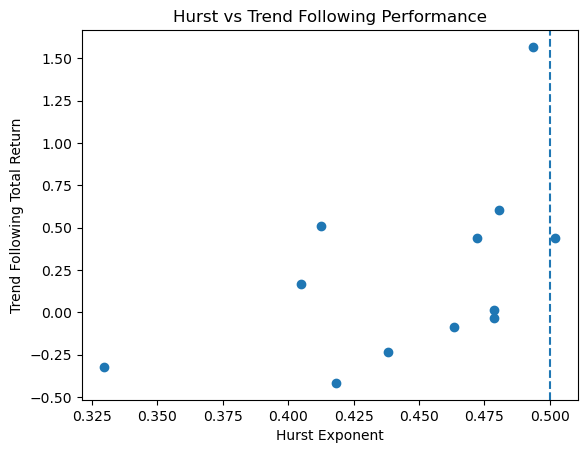

In [84]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(hurst_df['Hurst'], comparison_df['TF Return'])
plt.axvline(0.5, linestyle='--')
plt.xlabel('Hurst Exponent')
plt.ylabel('Trend Following Total Return')
plt.title('Hurst vs Trend Following Performance')
plt.show()


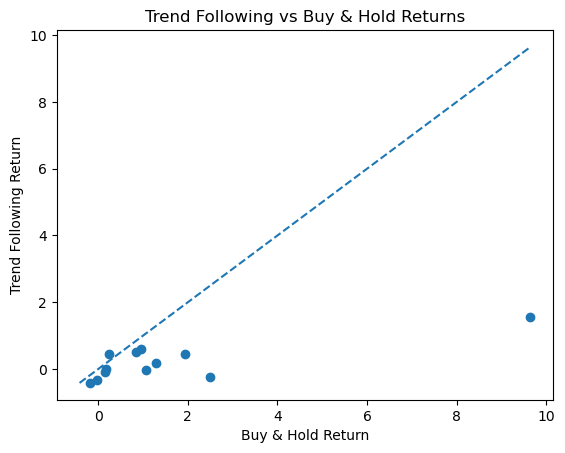

In [79]:
plt.figure()
plt.scatter(comparison_df['BH Return'], comparison_df['TF Return'])

min_val = min(comparison_df['BH Return'].min(), comparison_df['TF Return'].min())
max_val = max(comparison_df['BH Return'].max(), comparison_df['TF Return'].max())
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--')

plt.xlabel('Buy & Hold Return')
plt.ylabel('Trend Following Return')
plt.title('Trend Following vs Buy & Hold Returns')
plt.show()


# FOR RECURITMENT IN ALPHA FACTORY

In [11]:
def build_universe_panel(symbols, years=5):
    """
    Returns:
      prices: DataFrame (Date x Symbol) of Close prices
      rets:   DataFrame (Date x Symbol) of daily returns
    """
    prices = {}
    for sym in symbols:
        df = load_stooq_stock(sym, years=years)  # must include 'Close' and 'returns'
        prices[sym.upper()] = df['Close']
    
    prices = pd.DataFrame(prices).dropna(how='all').sort_index()
    rets = prices.pct_change()
    return prices, rets

In [12]:
def compute_tf_returns_for_universe(
    prices: pd.DataFrame,
    lookback: int
) -> pd.DataFrame:
    """
    prices : DataFrame (Date x Asset)
    returns: DataFrame of TF strategy returns per asset
    """
    daily_returns = prices.pct_change()
    tf_returns = pd.DataFrame(index=prices.index, columns=prices.columns)

    for asset in prices.columns:
        price = prices[asset]

        # Trend signal: sign of lookback return
        signal = np.sign(price / price.shift(lookback) - 1)

        # Position (shifted to avoid lookahead)
        position = signal.shift(1).fillna(0)

        # Strategy return
        tf_returns[asset] = position * daily_returns[asset]

    return tf_returns

In [13]:
def portfolio_trend_following(prices: pd.DataFrame, lookback: int):
    tf_returns = compute_tf_returns_for_universe(prices, lookback)

    # Equal-weight portfolio
    portfolio_tf = tf_returns.mean(axis=1)

    return portfolio_tf


In [14]:
symbols = [
    # Tech / Growth
    'NVDA.US','AAPL.US','MSFT.US','META.US','AMZN.US','GOOGL.US','AMD.US',

    # Cyclical
    'JPM.US','GS.US','XOM.US','CVX.US','CAT.US',

    # Defensive
    'PG.US','KO.US','UNH.US','COST.US',

    # ETFs
    'SPY.US','QQQ.US','IWM.US','XLK.US','XLF.US','XLE.US','XLV.US','TLT.US'
]
prices, rets = build_universe_panel(symbols, years=7)

portfolio_daily_tf = portfolio_trend_following(
    prices=prices,
    lookback=126   # use same horizon as CSM for fair comparison
)

In [15]:
portfolio_daily_tf

Data
2019-02-01         NaN
2019-02-04    0.000000
2019-02-05    0.000000
2019-02-06    0.000000
2019-02-07    0.000000
                ...   
2026-01-21    0.015721
2026-01-22    0.000478
2026-01-23   -0.003294
2026-01-26    0.000916
2026-01-27   -0.004279
Length: 1756, dtype: float64

In [16]:
portfolio_daily_TF = portfolio_daily_tf.fillna(0)
portfolio_daily_TF.describe()

count    1756.000000
mean        0.000216
std         0.008116
min        -0.082274
25%        -0.003095
50%         0.000199
75%         0.004285
max         0.031048
dtype: float64

In [17]:
portfolio_daily_TF.to_csv("portfolio_daily_TF.csv")

# For Mean Reversion NOW

In [19]:
import numpy as np
import pandas as pd

def portfolio_mean_reversion_long_short(
    prices: pd.DataFrame,
    mr_window: int = 20,
    z_entry: float = 1.5,
    z_exit: float = 0.5,
    trend_window: int = 200,
) -> pd.Series:
    """
    Long-short mean reversion with a trend filter.

    prices: DataFrame (Date x Asset) of prices
    returns: Series of daily portfolio returns
    """

    prices = prices.sort_index()
    rets = prices.pct_change()

    # Rolling stats for z-score
    ma = prices.rolling(mr_window).mean()
    sd = prices.rolling(mr_window).std()

    z = (prices - ma) / sd

    # Long-term trend filter
    trend_ma = prices.rolling(trend_window).mean()

    # Base MR positions: long when too low, short when too high
    pos = pd.DataFrame(0.0, index=prices.index, columns=prices.columns)

    pos[z <= -z_entry] = 1.0
    pos[z >=  z_entry] = -1.0

    # Exit rule: flatten when back near mean
    pos[(z.abs() < z_exit)] = 0.0

    # Trend filter: don't short strong uptrends; don't long strong downtrends
    pos[(prices > trend_ma) & (pos < 0)] = 0.0
    pos[(prices < trend_ma) & (pos > 0)] = 0.0

    # Avoid lookahead: today's position applied to tomorrow's return
    pos = pos.shift(1).fillna(0.0)

    # Equal-weight across active positions each day
    active_count = (pos != 0).sum(axis=1).replace(0, np.nan)
    weights = pos.div(active_count, axis=0)  # each active position gets equal weight

    # Portfolio return = sum(weights * returns)
    portfolio_mr = (weights * rets).sum(axis=1).fillna(0.0)

    return portfolio_mr


In [21]:
portfolio_daily_mr = portfolio_mean_reversion_long_short(
    prices=prices,
    mr_window=20,
    z_entry=1.5,
    z_exit=0.5,
    trend_window=200
)



In [23]:
portfolio_daily_mr.describe()

count    1756.000000
mean        0.000472
std         0.013609
min        -0.108583
25%        -0.002397
50%         0.000000
75%         0.004003
max         0.119511
dtype: float64

In [24]:
portfolio_daily_mr.to_csv("portfolio_daily_mr.csv")